### V1: Fine-Tune DistilBERT 
- Train Data

Trained on local machine with RTX 3050 x1

Leaderboard 
- Public Score: 0.85292
- Private Score: 0.87363

In [ ]:
import gc
import json
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from pathlib import Path
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

In [2]:
class Setting:
    seed = 42
    
    # data
    data = './data/pii-detection-removal-from-educational-data/test.json'
    
    # model
    model_final = './model/v1/final'
    max_length = 512
    stride = 64
    threshold = 0.95
    
    # hyperparameter
    batch_size = 8

In [3]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [4]:
df = pd.read_json(Setting.data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             10 non-null     int64 
 1   full_text            10 non-null     object
 2   tokens               10 non-null     object
 3   trailing_whitespace  10 non-null     object
dtypes: int64(1), object(3)
memory usage: 448.0+ bytes


In [5]:
df = df[['document', 'tokens', 'trailing_whitespace']]

In [6]:
ds = Dataset.from_pandas(df)

In [7]:
del df
gc.collect()

95

In [8]:
def tokenize(example, tokenizer, max_length, stride):
    # Initialize lists to store tokenized text and token map
    text, token_map = [], []
    # Initialize index for token mapping
    idx = 0
    # Iterate over tokens and trailing whitespace in the example
    for t, ws in zip(example["tokens"], example["trailing_whitespace"]):
        # Append token to the text list
        text.append(t)

        # Extend token map with index for the current token repeated for its length
        token_map.extend([idx] * len(t))

        # If there is trailing whitespace after the token, append a space to the text and mark its position as -1 in the token map
        if ws:
            text.append(" ")
            token_map.append(-1)

        # Increment the index for token mapping
        idx += 1

    # Tokenize the text using the provided tokenizer
    tokenized = tokenizer("".join(text), 
                          return_offsets_mapping=True,
                          truncation=True,  
                          max_length=max_length,  
                          stride=stride,  
                          return_overflowing_tokens=True)  

    # Return the tokenized text along with the token map
    return {
        **tokenized, 
        "token_map": token_map, 
    }

In [9]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_final)

ds = ds.map(tokenize, 
                      fn_kwargs={
                          "tokenizer": tokenizer, 
                          "max_length": Setting.max_length, 
                          "stride": Setting.stride}, num_proc=2)
ds

#model = AutoModelForTokenClassification.from_pretrained(Setting.model_final)


Map (num_proc=2):   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset({
    features: ['document', 'tokens', 'trailing_whitespace', 'input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'token_map'],
    num_rows: 10
})

In [10]:
gc.collect()

36

In [11]:
model = AutoModelForTokenClassification.from_pretrained(Setting.model_final)
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)
args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=1, 
    report_to="none",
)
trainer = Trainer(
    model=model, 
    args=args, 
    data_collator=collator, 
    tokenizer=tokenizer,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [12]:
def backwards_map_preds(sub_predictions, max_len, stride):
    if max_len != 1: # nothing to map backwards if sequence is too short to be split in the first place
        if i == 0:
            # First sequence needs no SEP token (used to end a sequence)
            sub_predictions = sub_predictions[:,:-1,:]
        elif i == max_len-1:
            # End sequence needs to CLS token + Stride tokens 
            sub_predictions = sub_predictions[:,1+stride:,:] # CLS tokens + Stride tokens
        else:
            # Middle sequence needs to CLS token + Stride tokens + SEP token
            sub_predictions = sub_predictions[:,1+stride:-1,:]
    return sub_predictions

def backwards_map_(row_attribute, max_len, stride):
    # Same logics as for backwards_map_preds - except lists instead of 3darray
    if max_len != 1:
        if i == 0:
            row_attribute = row_attribute[:-1]
        elif i == max_len-1:
            row_attribute = row_attribute[1+stride:]
        else:
            row_attribute = row_attribute[1+stride:-1]
    return row_attribute

In [13]:
preds = []
ds_dict = {
    "document":[],
    "token_map":[],
    "offset_mapping":[],
    "tokens":[]
}

for row in ds:
    # keys that need to be re-assembled
    row_preds = []
    row_offset = []
    
    for i, y in enumerate(row["offset_mapping"]):
        # create new datasset for each of of the splits per document
        x = Dataset.from_dict({
            #"token_type_ids":[row["token_type_ids"][i]],
            "input_ids":[row["input_ids"][i]],
            "attention_mask":[row["attention_mask"][i]],
            "offset_mapping":[row["offset_mapping"][i]]
        })
        
        with torch.no_grad():
            # predict for that split        
            pred = trainer.predict(x).predictions
        # removing the stride and additional CLS & SEP that are created
        row_preds.append(backwards_map_preds(pred, len(row["offset_mapping"]), Setting.stride))
        row_offset += backwards_map_(y, len(row["offset_mapping"]), Setting.stride)
    
    # Finalize row
    ds_dict["document"].append(row["document"])
    ds_dict["tokens"].append(row["tokens"])
    ds_dict["token_map"].append(row["token_map"])
    ds_dict["offset_mapping"].append(row_offset)
    
    # Finalize prediction collection by concattenating
    p_concat = np.concatenate(row_preds, axis = 1)
    preds.append(p_concat)

In [14]:
del ds
gc.collect()

79

In [15]:
config = json.load(open(Path(Setting.model_final) / "config.json"))
id2label = config["id2label"]

preds_final = []
for predictions in preds:
    predictions_softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis = 2).reshape(predictions.shape[0],predictions.shape[1],1)
    predictions = predictions.argmax(-1)
    predictions_without_O = predictions_softmax[:,:,:12].argmax(-1)
    O_predictions = predictions_softmax[:,:,12]

    threshold = Setting.threshold
    preds_final.append(np.where(O_predictions < threshold, predictions_without_O , predictions))

In [16]:
ds = Dataset.from_dict(ds_dict)
pairs = []
document, token, label, token_str = [], [], [], []
for p, token_map, offsets, tokens, doc in zip(preds_final, ds["token_map"], ds["offset_mapping"], ds["tokens"], ds["document"]):
    for token_pred, (start_idx, end_idx) in zip(p[0], offsets):
        label_pred = id2label[str(token_pred)]

        if start_idx + end_idx == 0: continue

        if token_map[start_idx] == -1:
            start_idx += 1

        # ignore "\n\n"
        while start_idx < len(token_map) and tokens[token_map[start_idx]].isspace():
            start_idx += 1

        if start_idx >= len(token_map): break

        token_id = token_map[start_idx]

        # ignore "O" predictions and whitespace preds
        if label_pred != "O" and token_id != -1:
            pair=(doc, token_id)

            if pair not in pairs:
                document.append(doc)
                token.append(token_id)
                label.append(label_pred)
                token_str.append(tokens[token_id])
                pairs.append(pair)

In [17]:
df = pd.DataFrame({
    "document": document,
    "token": token,
    "label": label,
    "token_str": token_str
})
df["row_id"] = list(range(len(df)))
display(df.head(100))

,document,token,label,token_str,row_id
0,7,9,B-NAME_STUDENT,Nathalie,0
1,7,10,I-NAME_STUDENT,Sylla,1
2,7,482,I-NAME_STUDENT,Nathalie,2
3,7,483,I-NAME_STUDENT,Sylla,3
4,7,741,B-NAME_STUDENT,Nathalie,4
5,7,742,I-NAME_STUDENT,Sylla,5
6,10,0,B-NAME_STUDENT,Diego,6
7,10,1,I-NAME_STUDENT,Estrada,7
8,10,464,B-NAME_STUDENT,Diego,8
9,10,465,I-NAME_STUDENT,Estrada,9


In [18]:
df[["row_id", "document", "token", "label"]].to_csv("submission.csv", index=False)

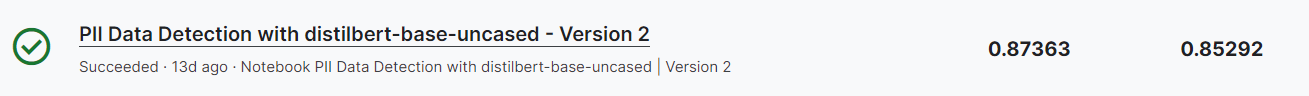